Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return bool(sum(self._rows) > 0)

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
    
    def n_possible_moves(self) -> int:
        return sum(self._rows)


## Sample (and silly) startegies 

In [4]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [7]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [8]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(6)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")

INFO:root:init : <1 3 5 7 9 11>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=8)
INFO:root:status: <1 3 5 7 1 11>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 7 1 11>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 2 5 7 0 11>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 1 5 7 0 11>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 1 2 7 0 11>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 1 2 7 0 11>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=5)
INFO:root:status: <0 1 2 2 0 11>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 1 1 2 0 11>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=2)
INFO:root:status: <0 1 1 0 0 11>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 1 0 0 0 11>
INFO:root:ply: player 0 plays Nimply(row=5, num_

# Our Solution

In [9]:
NUM_MATCHES = 1000
NIM_SIZE = 5
N_GAMES_SIMULATED_PER_MOVE = 100

USE_SMART = True

nim = Nim(NIM_SIZE)

## Methods

In [10]:
def generate_all_possible_moves(state: Nim) -> list:
    return [Nimply(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]

def max_num_objects(state: Nim) -> dict:
    return {r: c for r, c in enumerate(state.rows)}

def smart_sort_moves(state: Nim, possible_moves: list) -> list:
    dict_max_nims = max_num_objects(nim)
    list_diffs = []

    for move in possible_moves: 
        row = move[0]
        num_objects = move[1]
        diff = dict_max_nims[row] - num_objects
        diff = diff if diff > 0 else float("inf")
        list_diffs.append(diff)

    # argsort list_diffs
    list_diffs = np.array(list_diffs)
    list_diffs_args = list_diffs.argsort()

    # generate two lists, one with odd and one with even positions 
    list_odd = []
    list_even = []

    for i in range(len(list_diffs_args)):
        if i%2 == 0:
            list_odd.append(list_diffs_args[i])
        else:
            list_even.append(list_diffs_args[i])

    # swap list_odd
    gaussian_list = list_odd[::-1]
    gaussian_list.extend(list_even)
    return gaussian_list

def generate_all_possible_moves_smartly(state: Nim) -> list:
    possible_moves = generate_all_possible_moves(state)
    smart_indexes = smart_sort_moves(state, possible_moves)
    smart_moves = [possible_moves[index] for index in smart_indexes]
    return smart_moves


def sample_gaussian_move(state: Nim, std: float = 3, use_smart: bool = False) -> Nimply:
    possible_moves = generate_all_possible_moves(state) if not use_smart else generate_all_possible_moves_smartly(state)
    move = round(random.gauss(round(len(possible_moves)/2), std))
    move = max(0, min(move, len(possible_moves)-1))
    move = int(move)
    return possible_moves[move], move

def gaussian_sampler(state: Nim, std: float = 3, use_smart: bool = False) -> Nimply:
    return sample_gaussian_move(state, std, use_smart=use_smart)[0]

def generate_game(state: Nim, use_smart: bool = False, std: float = 3.0) -> tuple:
    strategy = (gaussian_sampler, pure_random)
    temp_state = deepcopy(state)
    first_move = None 
    player = 0 
    while temp_state:
        ply = strategy[player](temp_state) if player != 0 else strategy[player](temp_state, use_smart=use_smart, std=std)
        first_move = ply if first_move is None else first_move
        temp_state.nimming(ply)
        player = 1 - player
    return (first_move, player)

def generate_games(state: Nim, n: int = 1000, use_smart: bool = False, std: float = 3.0) -> list:
    return [generate_game(state, use_smart=use_smart, std=std) for _ in range(n)]

def choose_best_move(state: Nim, n_games: int = 1000, use_smart: bool = False, std: float = 3.0) -> Nimply:
    games = generate_games(state, n_games, use_smart=use_smart, std=std)
    winning_moves = np.array([game[0] for game in games if game[1] == 0])
    moves, count = np.unique(winning_moves, return_counts=True, axis=0)
    best_move = moves[np.argmax(count)] if len(moves) > 0 else generate_all_possible_moves(state)[0]
    return Nimply(best_move[0], best_move[1])

def our_strategy(state: Nim, use_smart: bool = False, std: float = 3.0) -> Nimply:
    return choose_best_move(state, n_games=N_GAMES_SIMULATED_PER_MOVE, use_smart=use_smart, std=std)

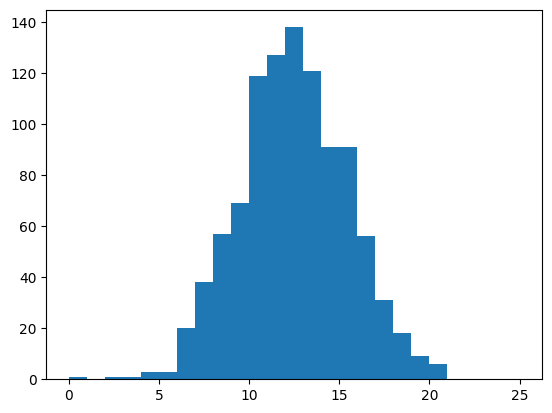

In [11]:
def plot_hist_moves(state: Nim, std: float = 3, use_smart: bool = False) -> Nimply:
    list = []
    for i in range(1000):
        _, num = sample_gaussian_move(state=state, std=std, use_smart=use_smart)
        list.append(num)

    plt.hist(list, bins=state.n_possible_moves(), range=(0,state.n_possible_moves())) 
    plt.show()

plot_hist_moves(nim, use_smart=USE_SMART)
# STD makes sense between 2 and 6

## Tournament: Choose the best STD

Tournament done with 1000 matches between each pair of STDs. The STD with the highest number of wins advances to the next round. The tournament ends when there is only one STD left.

Total number of matches in one tournament: 1000 * (8+4+2+1) = 15000

#### BEST STDs

USE_SMART = True: std = 2.0

USE_SMART = False: std = 

In [12]:
def pairings(std_list: list): 
    # generate pairings of std
    random_std_list = []
    assert len(std_list)%2 == 0
    
    for i in range(int(len(std_list)/2)):
        element = random.choice(std_list)
        std_list = np.delete(std_list, np.where(std_list == element))
        element2 = random.choice(std_list)
        std_list = np.delete(std_list, np.where(std_list == element2))
        random_std_list.append((element, element2))
    return random_std_list

def sigma_tournament(std_list: list) -> list:
    while len(std_list) > 1: 
        random_std_list = pairings(std_list)
        std_list = []
        for std_pair in random_std_list:
            std1 = std_pair[0]
            std2 = std_pair[1]

            std1_wins = 0 
            std2_wins = 0

            for _ in tqdm(range(NUM_MATCHES)):
                nim = Nim(NIM_SIZE)
                player = random.randint(0, 1)
                while nim:
                    ply = our_strategy(nim, std=std1, use_smart=USE_SMART) if player == 0 else our_strategy(nim, std=std2, use_smart=USE_SMART)
                    nim.nimming(ply)
                    player = 1 - player
                std1_wins += 1 if player == 0 else 0
                std2_wins += 1 if player == 1 else 0
            std_list.append(std1 if std1_wins > std2_wins else std2)
    return std_list[0]

In [13]:
std_list = np.linspace(2, 6, 16)
std_list = np.round(std_list, 2)

best_std_smart = sigma_tournament(std_list)
print(best_std_smart)

100%|██████████| 1000/1000 [01:49<00:00,  9.10it/s]


In [14]:
# saved the result after the tournament, to avoid to run it again and again
#best_std_smart = 2.0
best_std_random = 2.0

## Comparison between our solution and the ones provided

### Our Solution vs. Pure Random

In [15]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim) if player != 0 else players[player](nim, use_smart=USE_SMART, std=best_std_smart if USE_SMART else best_std_random)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, pure_random)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

 55%|█████▍    | 547/1000 [00:27<00:23, 19.65it/s]


KeyboardInterrupt: 

### Our Solution vs. Gabriele's Solution

In [ ]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim) if player != 0 else players[player](nim, use_smart=USE_SMART, std=best_std_smart if USE_SMART else best_std_random)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, gabriele)
print(f"Our Solution vs Opponent => {ev_optimalvsexpert}")

### Smart vs. Random Array 

In [ ]:
def evaluate(strategy1, strategy2):
    """evaluate put a first strategy versus a second one for a certain number of times, the results is the ratio 
    between the won matches and the total number of played matches"""
    players = (strategy1, strategy2)
    won = 0

    for _ in tqdm(range(NUM_MATCHES)):
        nim = Nim(NIM_SIZE)
        player = random.randint(0,1) # make a random start
        while nim:
            ply = players[player](nim, use_smart = False, std = best_std_random) if player != 0 else players[player](nim, use_smart=True, std=best_std_smart)
            nim.nimming(ply)
            player = 1 - player
        if player == 0:
            won += 1
    return round(won / NUM_MATCHES, 2)

ev_optimalvsexpert = evaluate(our_strategy, our_strategy)
print(f"Our Smart Solution vs Our 'Random' Solution => {ev_optimalvsexpert}")